In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster

import matplotlib.pyplot as plt
import cartopy
import cmocean
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from scipy import stats
import utils

import metpy.calc as mpcalc

#### Define case and path

In [3]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'

In [4]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

#### Define variable list

In [5]:
variables = ['photoC_sp_zint','photoC_diat_zint']
cice_vars = ['aice']
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','time','dz','TAREA','REGION_MASK'] + variables + list(coords.values())

### Grab one year to figure out how to clip the region

In [6]:
ds_fosi_x01 = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.201001-201012.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True) #, preprocess=preprocess)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x01 = xr.merge([ds_fosi_x01,ds_tmp])

starting on  photoC_sp_zint
starting on  photoC_diat_zint


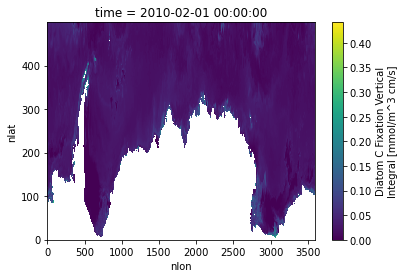

In [7]:
ds_fosi_x01.photoC_diat_zint.isel(time=0,nlat=slice(0,500)).plot()

In [8]:
ds_fosi_x01['NPP'] = ds_fosi_x01.photoC_diat_zint + ds_fosi_x01.photoC_sp_zint

In [9]:
def preprocess(ds):
    ds=ds.isel(z_t_150m=0)
    ds=ds.isel(z_t=0)
    ds=ds.isel(nlat=slice(0,500))
    return ds

#### Get grid

In [10]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3').isel(nlat=slice(0,500))
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

### Now get all the years using a preprocessing clipping

In [11]:
ds_fosi_x01 = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x01 = xr.merge([ds_fosi_x01,ds_tmp])

starting on  photoC_sp_zint
starting on  photoC_diat_zint


In [12]:
ds_fosi_x01['NPP'] = ds_fosi_x01.photoC_diat_zint + ds_fosi_x01.photoC_sp_zint

In [13]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ice/proc/tseries/month_1'

In [14]:
def preprocess(ds):
    ds=ds.isel(nj=slice(0,500))
    return ds

In [15]:
ds_fosi_x01_ice = xr.Dataset()

for var in cice_vars:
    
    print('starting on ', var)
    ################ FOSI
    
    files = sorted(glob(f'{path}/{case}.cice.h.{var}.??????-??????.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)
        
    ds_fosi_x01_ice = xr.merge([ds_fosi_x01_ice,ds_tmp])

starting on  aice


In [16]:
ds_fosi_x01_ice

<xarray.Dataset>
Dimensions:      (d2: 2, nc: 5, ni: 3600, nj: 500, nkbio: 5, nkice: 4, nksnow: 1, nvertices: 4, time: 768)
Coordinates:
    TLON         (nj, ni) float32 dask.array<chunksize=(500, 3600), meta=np.ndarray>
    TLAT         (nj, ni) float32 dask.array<chunksize=(500, 3600), meta=np.ndarray>
    ULON         (nj, ni) float32 dask.array<chunksize=(500, 3600), meta=np.ndarray>
    ULAT         (nj, ni) float32 dask.array<chunksize=(500, 3600), meta=np.ndarray>
  * time         (time) object 1958-02-01 00:00:00 ... 2022-01-01 00:00:00
Dimensions without coordinates: d2, nc, ni, nj, nkbio, nkice, nksnow, nvertices
Data variables: (12/22)
    NCAT         (nc) float32 dask.array<chunksize=(5,), meta=np.ndarray>
    VGRDi        (nkice) float32 dask.array<chunksize=(4,), meta=np.ndarray>
    VGRDs        (nksnow) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    VGRDb        (nkbio) float32 dask.array<chunksize=(5,), meta=np.ndarray>
    tmask        (nj, ni) float32 dask.array<chunksize=(500, 3600), meta=np.ndarray>
    blkmask      (nj, ni) float32 dask.array<chunksize=(500, 3600), meta=np.ndarray>
    ...           ...
    lont_bounds  (nj, ni, nvertices) float32 dask.array<chunksize=(500, 3600, 4), meta=np.ndarray>
    latt_bounds  (nj, ni, nvertices) float32 dask.array<chunksize=(500, 3600, 4), meta=np.ndarray>
    lonu_bounds  (nj, ni, nvertices) float32 dask.array<chunksize=(500, 3600, 4), meta=np.ndarray>
    latu_bounds  (nj, ni, nvertices) float32 dask.array<chunksize=(500, 3600, 4), meta=np.ndarray>
    time_bounds  (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    aice         (time, nj, ni) float32 dask.array<chunksize=(12, 500, 3600), meta=np.ndarray>

In [17]:
ds_fosi_x01_ice = ds_fosi_x01_ice.rename({'ni': 'nlon','nj': 'nlat',})

In [18]:
ds_fosi_x01["time"] = ds_fosi_x01.time_bound.compute().mean(dim="d2")
ds_fosi_x01["time"].isel(time=-10)

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2021, 3, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    z_t       float32 500.0
    z_t_150m  float32 500.0
    time      object 2021-03-16 12:00:00

In [19]:
### trim off 1958-1963 and 2006-2021 since these years aren't in the hi res run
#ds_fosi_x01 = ds_fosi_x01.isel(time=slice(0,576))

### spin up dask

In [20]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [21]:
# cluster, client = get_ClusterClient()
# cluster.scale(12) 
# client

In [22]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1/'
variables = ['photoC_sp_zint','photoC_diat_zint','IFRAC']

In [23]:
ds_fosi_x1 = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x1 = xr.merge([ds_fosi_x1,ds_tmp])

starting on  photoC_sp_zint
starting on  photoC_diat_zint
starting on  IFRAC


In [24]:
ds_fosi_x1['NPP'] = ds_fosi_x1.photoC_sp_zint + ds_fosi_x1.photoC_diat_zint

In [25]:
ds_grid_x1 = pop_tools.get_grid('POP_gx1v7')
lons_x1=ds_grid_x1.TLONG
lats_x1=ds_grid_x1.TLAT
area_x1=ds_grid_x1.TAREA
area_m_x1=ds_grid_x1.TAREA * 1e-4
lons_norm_x1 = utils.normal_lons(lons_x1)

### Make a comparison map.

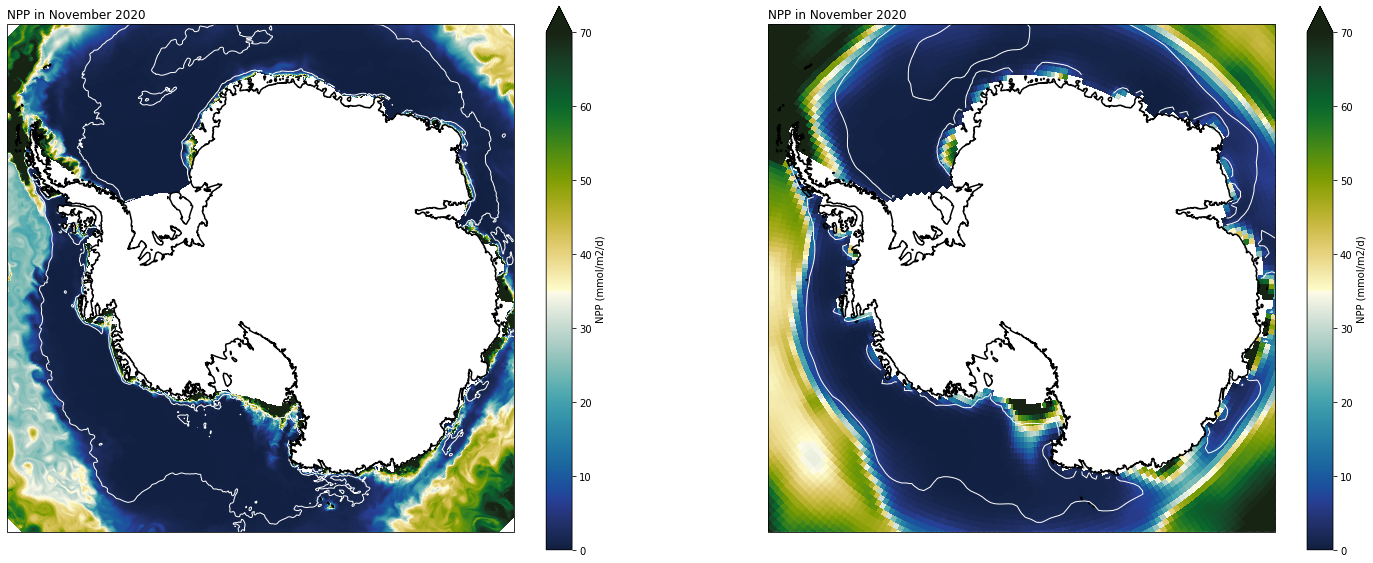

In [26]:
fig = plt.figure(figsize=(25,10))

siz_lev = [0.85]

## hi res
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
ax.set_title('NPP in November 2020', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01["NPP"].isel(time=-14)*0.01*86400)

pc = ax.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta, vmin=0,vmax=70)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01_ice["aice"].isel(time=-14))
cs = ax.contour(lon,lat,field, colors='white',
levels = siz_lev,
linewidths = 1,
transform=ccrs.PlateCarree(),label='SIZ')

ax.coastlines('10m',linewidth=1.5)

fig.colorbar(pc,extend='max', label= 'NPP (mmol/m2/d)');


## low res
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
ax.set_title('NPP in November 2020', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1["NPP"].isel(time=-14)*0.01*86400)

pc = ax.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta, vmin=0,vmax=70)

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1["IFRAC"].isel(time=-14))
cs = ax.contour(lon,lat,field, colors='white',
levels = siz_lev,
linewidths = 1,
transform=ccrs.PlateCarree(),label='SIZ')

ax.coastlines('10m',linewidth=1.5)

fig.colorbar(pc,extend='max', label= 'NPP (mmol/m2/d)');


#fig.savefig('/glade/work/kristenk/figs/antarc_diatNPP_01oct.png', bbox_inches='tight', dpi=300, format='png');

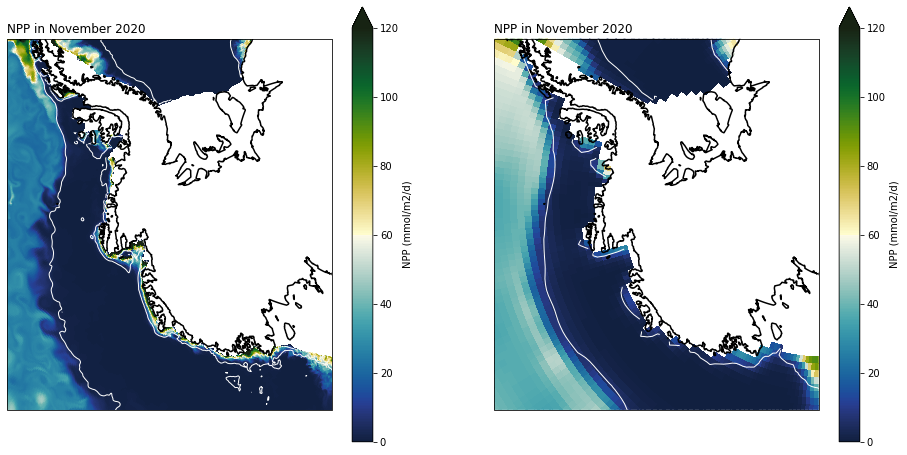

In [27]:
fig = plt.figure(figsize=(16,8))

siz_lev = [0.85]

## hi res
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-130, -60, -90, -65], ccrs.PlateCarree())
ax.set_title('NPP in November 2020', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01["NPP"].isel(time=-14)*0.01*86400)

pc = ax.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta, vmin=0,vmax=120)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01_ice["aice"].isel(time=-14))
cs = ax.contour(lon,lat,field, colors='white',
levels = siz_lev,
linewidths = 1,
transform=ccrs.PlateCarree(),label='SIZ')

ax.coastlines('10m',linewidth=1.5)

fig.colorbar(pc,extend='max', label= 'NPP (mmol/m2/d)');


## low res
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-130, -60, -90, -65], ccrs.PlateCarree())
ax.set_title('NPP in November 2020', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1["NPP"].isel(time=-14)*0.01*86400)

pc = ax.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta, vmin=0,vmax=120)

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1["IFRAC"].isel(time=-14))
cs = ax.contour(lon,lat,field, colors='white',
levels = siz_lev,
linewidths = 1,
transform=ccrs.PlateCarree(),label='SIZ')

ax.coastlines('10m',linewidth=1.5)

fig.colorbar(pc,extend='max', label= 'NPP (mmol/m2/d)');


#fig.savefig('/glade/work/kristenk/figs/antarc_diatNPP_01oct.png', bbox_inches='tight', dpi=300, format='png');

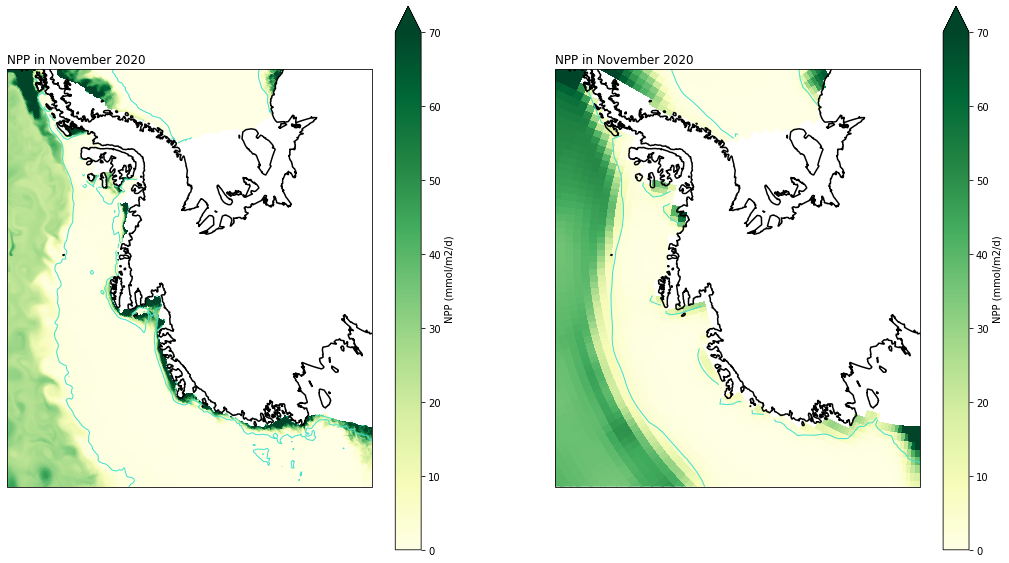

In [28]:
fig = plt.figure(figsize=(18,10))

siz_lev = [0.85]

## hi res
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-130, -60, -90, -65], ccrs.PlateCarree())
ax.set_title('NPP in November 2020', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01["NPP"].isel(time=-14)*0.01*86400)

pc = ax.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap='YlGn', vmin=0,vmax=70)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01_ice["aice"].isel(time=-14))
cs = ax.contour(lon,lat,field, colors='turquoise',
levels = siz_lev,
linewidths = 1,
transform=ccrs.PlateCarree(),label='SIZ')

ax.coastlines('10m',linewidth=1.5)

fig.colorbar(pc,extend='max', label= 'NPP (mmol/m2/d)');


## low res
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-130, -60, -90, -65], ccrs.PlateCarree())
ax.set_title('NPP in November 2020', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1["NPP"].isel(time=-14)*0.01*86400)

pc = ax.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap='YlGn', vmin=0,vmax=70)

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1["IFRAC"].isel(time=-14))
cs = ax.contour(lon,lat,field, colors='turquoise',
levels = siz_lev,
linewidths = 1,
transform=ccrs.PlateCarree(),label='SIZ')

ax.coastlines('10m',linewidth=1.5)

fig.colorbar(pc,extend='max', label= 'NPP (mmol/m2/d)');


#fig.savefig('/glade/work/kristenk/figs/antarc_diatNPP_01oct.png', bbox_inches='tight', dpi=300, format='png');

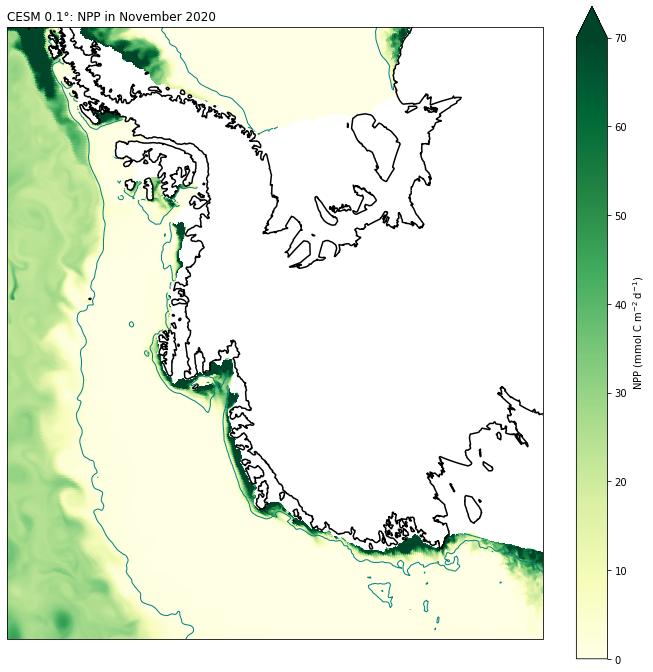

In [29]:
fig = plt.figure(figsize=(12,12))

siz_lev = [0.85]

## hi res
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-130, -60, -90, -65], ccrs.PlateCarree())
ax.set_title('CESM 0.1°: NPP in November 2020', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01["NPP"].isel(time=-14)*0.01*86400)

pc = ax.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap='YlGn', vmin=0,vmax=70)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01_ice["aice"].isel(time=-14))
cs = ax.contour(lon,lat,field, colors='teal',
levels = siz_lev,
linewidths = 1,
transform=ccrs.PlateCarree(),label='SIZ')

ax.coastlines('10m',linewidth=1.5)

fig.colorbar(pc,extend='max', label= 'NPP (mmol C m$^{-2}$ d$^{-1}$)');


fig.savefig('/glade/work/kristenk/figs/antarc_coastal_NPP_hires_Nov.png', bbox_inches='tight', dpi=300, format='png');

In [30]:
ds_fosi_x01["time"].isel(time=-12)

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2021, 1, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    z_t       float32 500.0
    z_t_150m  float32 500.0
    time      object 2021-01-16 12:00:00

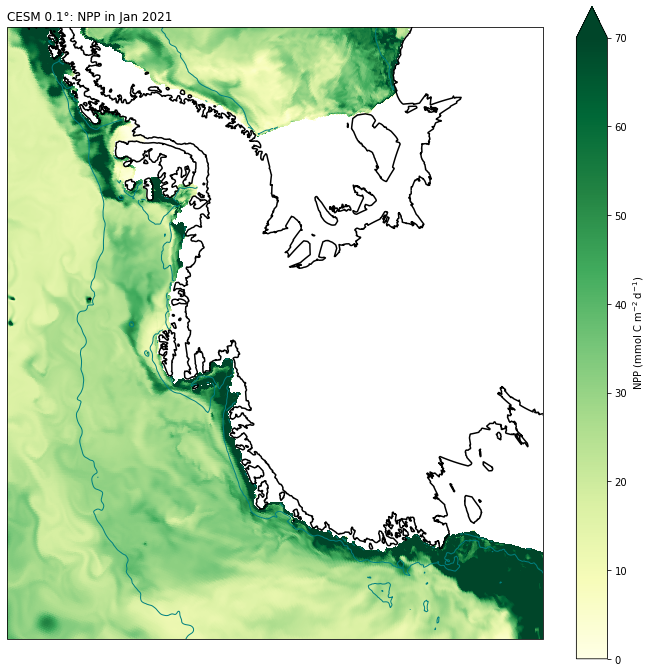

In [31]:
fig = plt.figure(figsize=(12,12))

siz_lev = [0.85]

## hi res
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-130, -60, -90, -65], ccrs.PlateCarree())
ax.set_title('CESM 0.1°: NPP in Jan 2021', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01["NPP"].isel(time=-12)*0.01*86400)

pc = ax.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap='YlGn', vmin=0,vmax=70)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01_ice["aice"].isel(time=-14))
cs = ax.contour(lon,lat,field, colors='teal',
levels = siz_lev,
linewidths = 1,
transform=ccrs.PlateCarree(),label='SIZ')

ax.coastlines('10m',linewidth=1.5)

fig.colorbar(pc,extend='max', label= 'NPP (mmol C m$^{-2}$ d$^{-1}$)');


fig.savefig('/glade/work/kristenk/figs/antarc_coastal_NPP_hires_Jan.png', bbox_inches='tight', dpi=300, format='png');

### get hi res feisty

In [32]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/'+case+'/FEISTY/FEISTY_'+case+'_202001-202012.nc' 

ds_2020_feisty = xr.open_dataset(path)
ds_2020_feisty = ds_2020_feisty.isel(nlat=slice(0,500))

In [33]:
ds_2020_feisty

<xarray.Dataset>
Dimensions:     (fish: 8, group: 9, nlat: 500, nlon: 3600, time: 12)
Coordinates:
  * fish        (fish) object 'Sf' 'Sp' 'Sd' 'Mf' 'Mp' 'Md' 'Lp' 'Ld'
  * group       (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat        (nlat) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * nlon        (nlon) int64 0 1 2 3 4 5 6 ... 3594 3595 3596 3597 3598 3599
  * time        (time) datetime64[ns] 2020-01-31 2020-02-29 ... 2020-12-31
Data variables:
    production  (time, fish, nlat, nlon) float64 ...
    biomass     (time, group, nlat, nlon) float64 ...
    fish_yield  (time, fish, nlat, nlon) float64 ...

### get low res feisty

In [34]:

year = 2020

print(year)
yr4="{:04d}".format(year)
path = '/glade/scratch/kristenk/feisty_output/002branch3/hist/companion.' + yr4 + '.zarr'

ds_tmp = xr.open_zarr(path, consolidated=False)

#convert to monthly
ds_2020_feisty_lr = ds_tmp.resample({'time':'M'}).mean(dim='time').compute()


2020


In [35]:
demersals_ss = ds_2020_feisty.biomass.sel(group='Sd').isel(time=10) + ds_2020_feisty.biomass.sel(group='Md').isel(time=10) + ds_2020_feisty.biomass.sel(group='Ld').isel(time=10)

In [36]:
demersals_ss_lr = ds_2020_feisty_lr.biomass.sel(group='Sd').isel(time=10) + ds_2020_feisty_lr.biomass.sel(group='Md').isel(time=10) + ds_2020_feisty_lr.biomass.sel(group='Ld').isel(time=10)

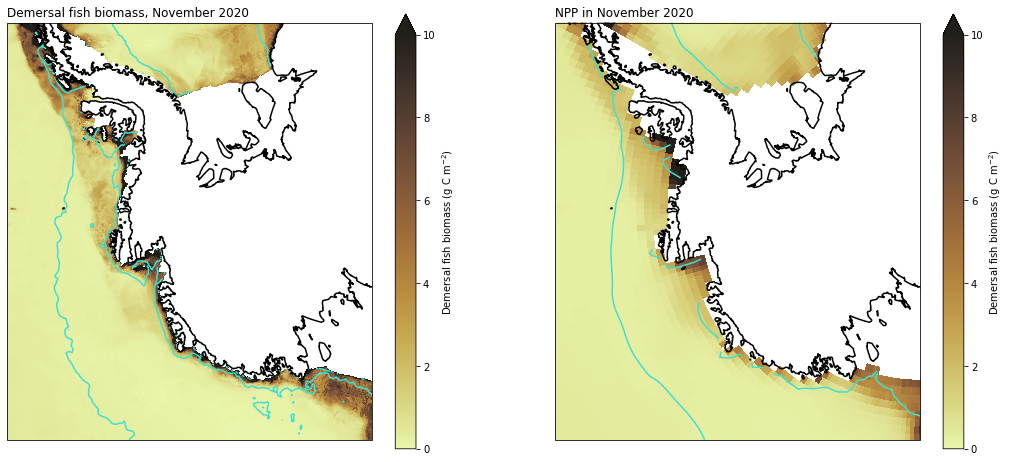

In [37]:
fig = plt.figure(figsize=(18,8))

siz_lev = [0.85]

## hi res
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-130, -60, -90, -65], ccrs.PlateCarree())
ax.set_title('Demersal fish biomass, November 2020', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, demersals_ss)

pc = ax.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap=cmocean.cm.turbid, vmin=0,vmax=10)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01_ice["aice"].isel(time=-14))
cs = ax.contour(lon,lat,field, colors='turquoise',
levels = siz_lev,
linewidths = 1.5,
transform=ccrs.PlateCarree(),label='SIZ')

ax.coastlines('10m',linewidth=1.5)

fig.colorbar(pc,extend='max', label= 'Demersal fish biomass (g C m$^{-2}$)');


## low res
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-130, -60, -90, -65], ccrs.PlateCarree())
ax.set_title('NPP in November 2020', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, demersals_ss_lr)

pc = ax.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap=cmocean.cm.turbid, vmin=0,vmax=10)

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1["IFRAC"].isel(time=-14))
cs = ax.contour(lon,lat,field, colors='turquoise',
levels = siz_lev,
linewidths = 1.5,
transform=ccrs.PlateCarree(),label='SIZ')

ax.coastlines('10m',linewidth=1.5)

fig.colorbar(pc,extend='max', label= 'Demersal fish biomass (g C m$^{-2}$)');


#fig.savefig('/glade/work/kristenk/figs/antarc_diatNPP_01oct.png', bbox_inches='tight', dpi=300, format='png');

In [38]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

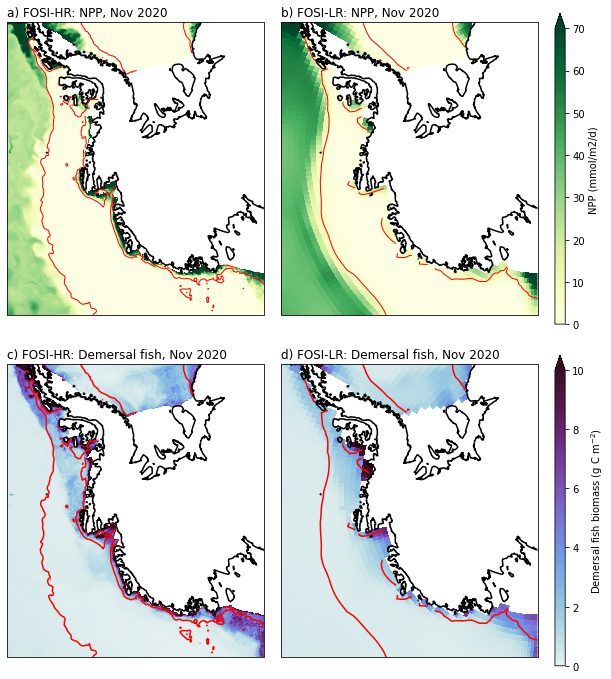

In [40]:
fig = plt.figure(figsize=(10, 12))
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1, 0.04))

prj = ccrs.SouthPolarStereo()

ax_npp_hr = plt.subplot(gs[0, 0], projection=prj)
ax_npp_lr = plt.subplot(gs[0, 1], projection=prj)
ax_dem_hr = plt.subplot(gs[1, 0], projection=prj)
ax_dem_lr = plt.subplot(gs[1, 1], projection=prj)

cax_npp = plt.subplot(gs[0, 2])
cax_dem = plt.subplot(gs[1, 2])



ax_npp_hr.set_title('a) FOSI-HR: NPP, Nov 2020', fontsize=12, loc='left')
ax_npp_hr.set_extent([-130, -60, -90, -65], ccrs.PlateCarree())
lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01["NPP"].isel(time=-14)*0.01*86400)

pc_npp = ax_npp_hr.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap='YlGn', vmin=0,vmax=70)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01_ice["aice"].isel(time=-14))
cs = ax_npp_hr.contour(lon,lat,field, colors='red',
levels = siz_lev,
linewidths = 1,
transform=ccrs.PlateCarree(),label='SIZ')

ax_npp_hr.coastlines('10m',linewidth=1.5)

##########

ax_npp_lr.set_title('b) FOSI-LR: NPP, Nov 2020', fontsize=12, loc='left')
ax_npp_lr.set_extent([-130, -60, -90, -65], ccrs.PlateCarree())
lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1["NPP"].isel(time=-14)*0.01*86400)

pc = ax_npp_lr.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap='YlGn', vmin=0,vmax=70)

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1["IFRAC"].isel(time=-14))
cs = ax_npp_lr.contour(lon,lat,field, colors='red',
levels = siz_lev,
linewidths = 1,
transform=ccrs.PlateCarree(),label='SIZ')

ax_npp_lr.coastlines('10m',linewidth=1.5)

#########
ax_dem_hr.set_title('c) FOSI-HR: Demersal fish, Nov 2020', fontsize=12, loc='left')
ax_dem_hr.set_extent([-130, -60, -90, -65], ccrs.PlateCarree())
lon,lat,field = utils.adjust_pop_grid(lons, lats, demersals_ss)

pc = ax_dem_hr.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap=cmocean.cm.dense, vmin=0,vmax=10)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01_ice["aice"].isel(time=-14))
cs = ax_dem_hr.contour(lon,lat,field, colors='red',
levels = siz_lev,
linewidths = 1.5,
transform=ccrs.PlateCarree(),label='SIZ')

ax_dem_hr.coastlines('10m',linewidth=1.5)


#################


ax_dem_lr.set_title('d) FOSI-LR: Demersal fish, Nov 2020', fontsize=12, loc='left')
ax_dem_lr.set_extent([-130, -60, -90, -65], ccrs.PlateCarree())
lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, demersals_ss_lr)

pc_dem = ax_dem_lr.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),cmap=cmocean.cm.dense, vmin=0,vmax=10)

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1["IFRAC"].isel(time=-14))
cs = ax_dem_lr.contour(lon,lat,field, colors='red',
levels = siz_lev,
linewidths = 1.5,
transform=ccrs.PlateCarree(),label='SIZ')

ax_dem_lr.coastlines('10m',linewidth=1.5)




cb_dem = plt.colorbar(pc_dem, cax=cax_dem, extend='max', label= 'Demersal fish biomass (g C m$^{-2}$)');
cb_npp = plt.colorbar(pc_npp, cax=cax_npp, extend='max', label= 'NPP (mmol/m2/d)');


fig.subplots_adjust(wspace=0.1,hspace=0.1)
fig.savefig('/glade/work/kristenk/figs/antarc_NPP_dems.png', bbox_inches='tight', dpi=300, format='png');
